# PREDICTING RSA CLUSTER LABELS

This notebook uses ANN and KNN to predict RSA cluster labels. In here, we try 50 models from 10 different seeds and chose the best according to validation accuracy and loss. Moreover, we perform 10 repeat 10-fold cross validation to ensure the model works well across a range of different training data folds.

## IMPORTING NECESSATY PACKAGES

In [126]:
from fragsys_analysis import *

In [73]:
import tensorflow as tf
from tensorflow import keras

from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## SOME FUNCTIONS

In [125]:
alpha = 0.75

PROPS_pred_KNN = {
    'boxprops':{'facecolor':'firebrick', 'edgecolor':'k', 'alpha' : alpha},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'},
    
}

PROPS_pred_ANN = {
    'boxprops':{'facecolor':'royalblue', 'edgecolor':'k', 'alpha' : alpha},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'},
    
}

PROPS_rand_KNN = {
    'boxprops':{'facecolor':'tomato', 'edgecolor':'k', 'alpha' : alpha},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'},
    
}

PROPS_rand_ANN = {
    'boxprops':{'facecolor':'cornflowerblue', 'edgecolor':'k', 'alpha' : alpha},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'},
    
}

PROPS_rand = {
    'boxprops':{'facecolor':'gold', 'edgecolor':'k', 'alpha' : alpha},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'},
    
}

flierprops_pred_KNN = dict(marker='o', markerfacecolor='firebrick', markersize=5,
                  linestyle='none', color="k", markeredgecolor='k')

flierprops_pred_ANN = dict(marker='o', markerfacecolor='royalblue', markersize=5,
                  linestyle='none', color="k", markeredgecolor='k')

flierprops_rand_KNN = dict(marker='o', markerfacecolor='tomato', markersize=5,
                  linestyle='none', color="k", markeredgecolor='k')

flierprops_rand_ANN = dict(marker='o', markerfacecolor='cornflowerblue', markersize=5,
                  linestyle='none', color="k", markeredgecolor='k')

flierprops_rand = dict(marker='o', markerfacecolor='gold', markersize=5,
                  linestyle='none', color="k", markeredgecolor='k')

In [117]:
def plot_loss(hist_df):
    n_epochs = len(hist_df)
    ax1 = sns.lineplot(x = list(range(n_epochs)), y = hist_df["loss"], c = "royalblue")#, label = "loss 11")
    sns.lineplot(x = list(range(n_epochs)), y = hist_df["val_loss"], c = "orange", ax = ax1)#, label = "val_loss 11")
    #plt.axvline(x = callback.stopped_epoch-100, linestyle = "--", color = "red", linewidth = 1.5)
    #ax.legend()
    #plt.show()

def plot_acc(hist_df):
    ax2 = sns.lineplot(x = list(range(n_epochs)), y = hist_df["accuracy"], c = "royalblue")#, label = "accuracy 11")
    sns.lineplot(x = list(range(n_epochs)), y = hist_df["val_accuracy"], c = "orange", ax = ax2)#, label = "val_accuracy 11")
    #ax.legend()
    #plt.axhline(y=0.9, linestyle = "--", color = "gray", linewidth = 0.5)
    #plt.axvline(x = callback.stopped_epoch-100, linestyle = "--", color = "red", linewidth = 1.5)
    #plt.axvline(x = 121, linestyle = "--", color = "red")

    plt.show()
    #############
    
def randomise(df, seed1):
    seed2 = seed1 + 1
    df_rand = df.sample(frac=1, random_state = seed1)
    random.seed(seed2)
    df_rand.index = random.sample(df_rand.index.tolist(), len(df))
    return df_rand

def get_confidences_df(preds_l, round_preds_l, vals_l):
    """
    preds_l: predictions probabilities
    round_preds_l: rounded predictions
    vals_l: real labels
    returns prediction confidence dataframe
    """
    confs = []
    for pred in preds_l:
        for row in pred:
            row = sorted(list(row), reverse = True) # sorts list of probabilities
            confidence = int(10*(row[0] - row[1])) # confidence score: goes from 0-10
            confs.append(confidence)
            
    vals = []
    preds = []
    ids = []
    for i in range(len(vals_l)):
        val = vals_l[i].label.tolist()
        idd = vals_l[i].index.tolist()
        pred = list(round_preds_l[i])
        vals.extend(val)
        preds.extend(pred)
        ids.extend(idd)
        
    conf_df = pd.DataFrame(list(zip(ids, confs, vals, preds)), columns = ["id", "conf", "val", "pred"]) # contains bs_id, real label, predicted label, and associated confidence
    
    un_confs = sorted(conf_df.conf.unique().tolist())
    covs = []
    accs = []
    for un_conf in un_confs:
        confi_df = conf_df[conf_df.conf >= un_conf]
        covs.append(len(confi_df)/len(conf_df))
        p_correct = len(confi_df[confi_df.val == confi_df.pred])/len(confi_df)
        accs.append(p_correct)
    
    conf_df_sum = pd.DataFrame(list(zip(un_confs, covs, accs)), columns = ["conf", "cov", "acc"]) # cumulative confidence dataframe with conf score, coverage, and average accuracy
    
    return conf_df, conf_df_sum

def plot_conf_acc_cov(conf_df_sum):
    # create figure and axis objects with subplots()
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    # make a plot
    ax.plot(conf_df_sum["conf"],
            conf_df_sum["cov"],
            color="darkgreen", 
            marker="o",
           label = "Coverage", markeredgewidth = 1, markeredgecolor = "k")
    # set x-axis label
    ax.set_xlabel("Confidence score", fontsize = 14)
    # set y-axis label
    ax.set_ylabel("Coverage",
                  color="k",
                  fontsize=14)
    
    #ax.set_yticks(np.arange(0.2,1.1, 0.1))
    #ax.set_ylim(0.175,1.025)
    #plt.legend()
    # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(conf_df_sum["conf"], conf_df_sum["acc"],color="purple",marker="D", label = "Average accuracy", markeredgewidth = 1, markeredgecolor = "k")
    ax2.set_ylabel("Average accuracy",color="k",fontsize=14)
    ax2.set_xlabel("Average confidence",color="k",fontsize=14)
    #ax2.set_yticks(np.arange(0.85,1.05, 0.05))
    #ax2.set_ylim(0.845,1.005)
    #plt.legend()
    plt.xticks(range(0,10))
    plt.show()

## READING INPUT DATA

In [2]:
main_dir = "."
results_dir = os.path.join(main_dir, "results")

rsa_cluster_dict = load_pickle(os.path.join(results_dir, "rsa_cluster_dict_NEW.pkl"))
cluster_membership = load_pickle(os.path.join(results_dir, "rsa_cluster_membership_NEW.pkl"))
rsa_profs = load_pickle(os.path.join(results_dir, "rsa_profs_NEW.pkl"))
ud_mat = pd.read_pickle(os.path.join(results_dir, "UD_df.pkl"))

## CREATING FEATURE DATAFRAME

In [103]:
max_len = max([len(v) for v in rsa_profs.values()])
bs_vectors = []
bs_vectors_dict = {}
for bs_id, rsa_sig in rsa_profs.items():
    rsa_sig_len = len(rsa_sig)
    rsa_range_prop = [0 for i in range(10)] # now let us change to 10
    for rsa in rsa_sig:
        prop_i = int(rsa/10) # 10 RSA BINS: b1 = [0,10), b2 = [10, 20), ... b10 = [90, MAX)
        if prop_i > 9: # if greater than 100, put in 10th bin
            prop_i = 9
        #print(prop_i)
        rsa_range_prop[prop_i] += 1
    rsa_range_prop = [round(i/rsa_sig_len, 3) for i in rsa_range_prop]
    rsa_range_prop.insert(0, rsa_sig_len/max_len) # ADDING BINDING SITE SIZE RELATIVE TO MAX SITE SIZE (IN THIS CASE 40)
    bs_vectors.append(rsa_range_prop)
    bs_vectors_dict[bs_id] = rsa_range_prop
    
vector_df = pd.DataFrame(bs_vectors) # obtaining RSA vectors, which are the 11-element features used for the machine learning

In [112]:
vector_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10
Q9UGL1_0_BS0,0.675,0.481,0.296,0.074,0.074,0.000,0.074,0.0,0.0,0.0,0.0
Q9UGL1_0_BS1,0.300,0.417,0.083,0.167,0.083,0.083,0.167,0.0,0.0,0.0,0.0
Q9UGL1_0_BS2,0.250,0.300,0.100,0.200,0.200,0.200,0.000,0.0,0.0,0.0,0.0


In [104]:
vector_df.index = list(rsa_profs.keys())

In [105]:
vector_df.shape

(293, 11)

In [113]:
vector_df.to_pickle("./results/rsa_vectors.pkl")

In [115]:
label_df = pd.DataFrame.from_dict(rsa_cluster_dict, orient = "index", columns = ["label"])

In [116]:
round(label_df.label.value_counts().sort_index()/len(label_df),2)

0    0.16
1    0.43
2    0.31
3    0.10
Name: label, dtype: float64

In [22]:
label_df.head(3)

,label
Q9UGL1_0_BS0,0
Q9UGL1_0_BS1,0
Q9UGL1_0_BS2,0


In [23]:
label_df.shape

(293, 1)

## CREATE MODEL

In [43]:
X = vector_df.sort_index() # here, X is still a dataframe. Thus, we maintain binding site IDs
y = label_df.sort_index()    # here, y is still a list

#### DATA SPLIT IN MODEL (10/11) (USED FOR TRAINING) AND BLIND (USED FOR FINAL TESTING) (1/11) STRATIFYING BY CLUSTER LABEL, SO THEY ARE BALANCED

In [44]:
X_model, X_blind, y_model, y_blind = train_test_split(X, y, test_size = 0.091, random_state = 12345, shuffle = True, stratify = y) ### X_blind and y_blind will be the blind test at the end

In [45]:
y_model.head(3)

,label
P47811_0_BS1,1
P0DTD1_0_BS23,1
Q96HY7_0_BS0,1


#### CLASSES ARE IMBALANCED DUE TO OUR TRAINING DATASET, BUT BOTH TRAINING AND TEST DATA HAVE THE SAME PROPORTION FOR EACH CLASS

In [46]:
print(len(X_model))
print(len(X_blind))
print(len(y_model))
print(len(y_blind))
for el in [0,1,2,3]:
    print(el, round(y_model.label.tolist().count(el)/len(y_model),2))
for el in [0,1,2,3]:
    print(el, round(y_blind.label.tolist().count(el)/len(y_blind),2))

266
27
266
27
0 0.16
1 0.43
2 0.31
3 0.1
0 0.15
1 0.44
2 0.3
3 0.11


#### CALLBACK TO GET BEST MODEL DURING TRAINING

In [76]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 100, verbose = 1, mode = 'max', restore_best_weights = True)

#### OBTAINING CLASS WEIGHTS TO MINIMISE EFFECT OF CLASS IMBALANCE IN TRAINING DATASET

In [48]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_model.label.tolist()),
                                                 y = np.array(y_model.label))
class_weights_dict = {i: class_weights[i] for i in np.unique(y_model)}

#### THE WEIGHT FOR EACH CLASS IS INVERSELY PROPORTIONAL TO THEIR FREQUENCY IN THE DATA SET

In [49]:
for k, v in class_weights_dict.items():
    print(k, round(v, 2))

0 1.58
1 0.58
2 0.8
3 2.56


#### DATA SPLIT IN MODEL_TRAIN (0.8) (USED FOR MODEL TRAINING) AND MODEL_VAL (0.2) (USED FOR MODEL VALIDATION DURING TRAINING) STRATIFYING BY CLUSTER LABEL, SO THEY ARE BALANCED

In [50]:
X_model_train, X_model_val, y_model_train, y_model_val = train_test_split(X_model, y_model, test_size = 0.2, random_state = 12345, shuffle = True, stratify = y_model)

In [51]:
len(set(X_model_train.index.tolist()).intersection(set(y_model_train.index.tolist())))/len(y_model_train)

1.0

In [52]:
len(set(X_model_val.index.tolist()).intersection(set(y_model_val.index.tolist())))/len(y_model_val)

1.0

#### TRAINING AND VALIDATION DATA HAVE THE SAME PROPORTION FOR EACH CLASS

In [53]:
print(len(X_model_train))
print(len(X_model_val))
print(len(y_model_train))
print(len(y_model_val))
for el in [0,1,2,3]:
    print(el, round(y_model_train.label.tolist().count(el)/len(y_model_train),2))
for el in [0,1,2,3]:
    print(el, round(y_model_val.label.tolist().count(el)/len(y_model_val),2))

212
54
212
54
0 0.16
1 0.43
2 0.31
3 0.1
0 0.17
1 0.43
2 0.31
3 0.09


# TRAINING

In [56]:
random.seed(1)

In [57]:
seeds = [random.randint(1, 100000) for i in range(10)] # [90015, 88091, 30338, 35897, 58161, 3551, 97160, 85734, 92233, 99814]

In [58]:
print(seeds) #[17612, 74607, 8272, 33433, 15456, 64938, 99741, 58916, 61899, 85406]

[17612, 74607, 8272, 33433, 15456, 64938, 99741, 58916, 61899, 85406]


In [80]:
seeds = [90015, 88091, 30338, 35897, 58161, 3551, 97160, 85734, 92233, 99814]

In [59]:
initializer = tf.keras.initializers.GlorotUniform(seed = 3551)

In [60]:
X_model_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10
P0DTD1_2_BS0,0.550,0.136,0.227,0.045,0.182,0.091,0.000,0.136,0.045,0.091,0.045
Q6PJP8_0_BS9,0.175,0.000,0.000,0.429,0.143,0.000,0.000,0.286,0.143,0.000,0.000
Q8IU60_0_BS0,0.300,0.333,0.000,0.167,0.250,0.083,0.083,0.000,0.000,0.000,0.083


### USING 10 DIFFERENT SEEDS, AND 50 MODELS WITHIN EACH SEED TO SELECT BEST MODEL

In [77]:
wd = "./results/ANN_results/diff_seeds"
#os.mkdir(wd)
for seed in seeds[0:1]:
    print("STARTING SEED {}".format(seed))
    seed_dir = os.path.join(wd, str(seed))
    mods_dir = os.path.join(seed_dir, "models")
    hist_dir = os.path.join(seed_dir, "hists")
    #os.mkdir(seed_dir)
    #os.mkdir(mods_dir)
    #os.mkdir(hist_dir)
    
    initializer_seed = tf.keras.initializers.GlorotUniform(seed = seed)
    for i in range(50):
        print(i+1)
        
        model_i = Sequential([
            Dense(units = 10, input_shape=(11,), activation = "relu", kernel_initializer = initializer_seed), # THIS IS THE MODEL
            Dense(units = 4, activation = "softmax", kernel_initializer = initializer_seed)
        ])
        
        model_i.compile(optimizer=Adam(learning_rate=0.01), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"]) # COMPILE MODEL
        
        hist_i = model_i.fit(
            x = X_model_train, y = y_model_train, batch_size = 32,
            callbacks = [callback], validation_data = (X_model_val, y_model_val),
            epochs = 300, shuffle = True, verbose = 0, class_weight =  class_weights_dict # TRAIN MODEL
        )
        final_epoch = callback.stopped_epoch-100
        final_acc = round(hist_i.history["val_accuracy"][final_epoch],2)
        
        model_i.save(os.path.join(mods_dir, "{}_{}_model_epoch_{}_train_acc_{}.h5".format(seed, i, final_epoch, round(final_acc, 2)))) # SAVING MODEL
        
        pd.DataFrame(hist_i.history).to_csv(os.path.join(hist_dir, "{}_{}_hist_epoch_{}_train_acc_{}.csv".format(seed, i, final_epoch, round(final_acc, 2))), index = False) # SAVING TRAINING DF

STARTING SEED 17612
1
Restoring model weights from the end of the best epoch: 42.
Epoch 142: early stopping
2
Restoring model weights from the end of the best epoch: 39.
Epoch 139: early stopping
3
Restoring model weights from the end of the best epoch: 42.
Epoch 142: early stopping
4
Restoring model weights from the end of the best epoch: 36.
Epoch 136: early stopping
5
Restoring model weights from the end of the best epoch: 40.
Epoch 140: early stopping
6
Restoring model weights from the end of the best epoch: 39.
Epoch 139: early stopping
7
Restoring model weights from the end of the best epoch: 32.
Epoch 132: early stopping
8
Restoring model weights from the end of the best epoch: 29.
Epoch 129: early stopping
9
Restoring model weights from the end of the best epoch: 30.
Epoch 130: early stopping
10
Restoring model weights from the end of the best epoch: 35.
Epoch 135: early stopping
11
Restoring model weights from the end of the best epoch: 36.
Epoch 136: early stopping
12
Restori

## REPEATED STRATIFIED K-FOLD CROSS-VALIDATION

In [78]:
rskf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10, random_state = 312) #sets are one after other. 0-10, is one 10-fold CV, 10-20, and so on

In [85]:
accs_pred_ANN = [] # prediction accuracies by ANN
accs_pred_KNN = [] # prediction accuracies by KNN

accs_rand = [] # prediction accuracies at random (randomly assigning a cluster label p=0.25 each)

accs_pred_ANN_rand = [] # prediction accuracies of randomly trained ANN
accs_pred_KNN_rand = [] # prediction accuracies of randomly trained KNN

knn = KNeighborsClassifier(n_neighbors=3) # starting KNN classifier

ann_good_preds = [] # predictions by ANN
ann_good_preds_round = [] # rounded predictions by ANN
ann_real_vals = [] # real labels
ann_rand_preds = [] # predictions by randomly trained ANN
ann_rand_preds_round = [] # rounded predictions of randomly trained ANN
#ann_


cv_dir = "./results/ANN_results/cv"
cv_good_dir = os.path.join(cv_dir, "good")
cv_rand_dir = os.path.join(cv_dir, "rand")

for i, (train_idx, val_idx) in enumerate(rskf.split(X_model, y_model)):
    
    seed = 3551
    seed1 = random.randint(1, 1000000000)
    seed2 = random.randint(1, 1000000000)
    #seed1 = 426359796
    #seed2 = 44036644
    print(seed1, seed2)
    
    bs_ids_train = X_model.index[train_idx].tolist() # THESE IDS WILL SUBSET BOTH DATASETS IN THE SAME WAY (INPUT FOR KNN AND INPUT FOR ANN)
    bs_ids_val = X_model.index[val_idx].tolist() # THESE IDS WILL SUBSET BOTH DATASETS IN THE SAME WAY (INPUT FOR KNN AND INPUT FOR ANN)
    
    X_train_ANN = X_model.loc[bs_ids_train, :]
    y_train_ANN = y_model.loc[bs_ids_train, :]
    
    X_train_ANN_rand = randomise(X_train_ANN, seed1)     # THIS WILL BE USED TO TRAIN ANN WITH RANDOMLY SHUFFLED TRAINING DATA
    y_train_ANN_rand = randomise(y_train_ANN, seed2)     # THIS WILL BE USED TO TRAIN ANN WITH RANDOMLY SHUFFLED TRAINING DATA
    
    X_val_ANN = X_model.loc[bs_ids_val, :]
    y_val_ANN = y_model.loc[bs_ids_val, :]
    
    X_train_KNN = ud_mat.loc[bs_ids_train, bs_ids_train]
    y_train_KNN = y_model.loc[bs_ids_train, :]
    
    X_train_KNN_rand = randomise(X_train_KNN, seed1)     # THIS WILL BE USED TO TRAIN KNN WITH RANDOMLY SHUFFLED TRAINING DATA
    y_train_KNN_rand = randomise(y_train_KNN, seed2)     # THIS WILL BE USED TO TRAIN KNN WITH RANDOMLY SHUFFLED TRAINING DATA
    
    X_val_KNN = ud_mat.loc[bs_ids_val, bs_ids_train]
    y_val_KNN = y_model.loc[bs_ids_val, :]
    
    #break
    
    ### PREDICTING WITH ANN ### well trained model
    
    X_model_train_ANN, X_model_val_ANN, y_model_train_ANN, y_model_val_ANN = train_test_split(
        X_train_ANN, y_train_ANN, test_size = 0.2, random_state = 12345,
        shuffle = True, stratify = y_train_ANN
    )
    
    class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train_ANN.label.tolist()),
                                                 y = np.array(y_train_ANN.label))
    
    class_weights_dict = {i: class_weights[i] for i in np.unique(y_train_ANN.label.tolist())}
    
    cv_model = Sequential([
        Dense(units = 10, input_shape=(11,), activation = "relu", kernel_initializer = initializer),
        Dense(units = 4, activation = "softmax", kernel_initializer = initializer)
    ])
    
    cv_model.compile(optimizer=Adam(learning_rate=0.01), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
    
    hist_cv_model = cv_model.fit(
        x = X_model_train_ANN, y = y_model_train_ANN, batch_size = 32,
        callbacks=[callback], validation_data = (X_model_val_ANN, y_model_val_ANN),
        epochs = 300, shuffle = True, verbose = 0, class_weight =  class_weights_dict
    )
    
    predictions = cv_model.predict(x = X_val_ANN, batch_size = 32, verbose = 0)
    rounded_predictions = np.argmax(predictions, axis = -1)
    CalculatedAccuracy = sum(rounded_predictions == y_val_ANN.label.tolist())/len(rounded_predictions)
    accs_pred_ANN.append(CalculatedAccuracy)
    ann_good_preds.append(predictions)
    ann_good_preds_round.append(rounded_predictions)
    ann_real_vals.append(y_val_ANN)
    
    final_epoch_good = callback.stopped_epoch-100
    if final_epoch_good == -100:
        final_epoch_good = 299
    final_acc_good = round(hist_cv_model.history["val_accuracy"][final_epoch_good],2)
        

    cv_model.save(os.path.join(cv_dir, "good", "mods", "{}_{}_good_model_epoch_{}_train_acc_{}.h5".format(seed, i, final_epoch_good, round(final_acc_good, 2))))
        
    pd.DataFrame(hist_cv_model.history).to_csv(os.path.join(cv_dir, "good", "hists", "{}_{}_good_hist_epoch_{}_train_acc_{}.csv".format(seed, i, final_epoch_good, round(final_acc_good, 2))), index = False)
        
        
        
    ### PREDICTING WITH ANN ### RANDOMLY trained model
    
    X_model_train_ANN_rand, X_model_val_ANN_rand, y_model_train_ANN_rand, y_model_val_ANN_rand = train_test_split(
        X_train_ANN_rand, y_train_ANN_rand, test_size = 0.2, random_state = 12345,
        shuffle = True, stratify = y_train_ANN_rand
    )
    
    class_weights_rand = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train_ANN_rand.label.tolist()),
                                                 y = np.array(y_train_ANN_rand.label))
    
    class_weights_dict_rand = {i: class_weights_rand[i] for i in np.unique(y_train_ANN_rand.label.tolist())}
    
    cv_model_rand = Sequential([
        Dense(units = 10, input_shape=(11,), activation = "relu", kernel_initializer = initializer),
        Dense(units = 4, activation = "softmax", kernel_initializer = initializer)
    ])
    
    cv_model_rand.compile(optimizer=Adam(learning_rate=0.01), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
    
    hist_cv_model_rand = cv_model_rand.fit(
        x = X_model_train_ANN_rand, y = y_model_train_ANN_rand, batch_size = 32,
        callbacks=[callback], validation_data = (X_model_val_ANN_rand, y_model_val_ANN_rand),
        epochs = 300, shuffle = True, verbose = 0, class_weight =  class_weights_dict_rand
    )
    
    predictions_rand = cv_model_rand.predict(x = X_val_ANN, batch_size = 32, verbose = 0)
    rounded_predictions_rand = np.argmax(predictions_rand, axis = -1)
    CalculatedAccuracy_rand = sum(rounded_predictions_rand == y_val_ANN.label.tolist())/len(rounded_predictions_rand)
    accs_pred_ANN_rand.append(CalculatedAccuracy_rand)
    ann_rand_preds.append(predictions_rand)
    ann_rand_preds_round.append(rounded_predictions_rand)
    
    final_epoch_rand = callback.stopped_epoch-100
    if final_epoch_rand == -100:
        final_epoch_rand = 299
    final_acc_rand = round(hist_cv_model_rand.history["val_accuracy"][final_epoch_rand],2)
        

    cv_model_rand.save(os.path.join(cv_dir, "rand", "mods", "{}_{}_rand_model_epoch_{}_train_acc_{}.h5".format(seed, i, final_epoch_rand, round(final_acc_rand, 2))))
        
    pd.DataFrame(hist_cv_model_rand.history).to_csv(os.path.join(cv_dir, "rand", "hists", "{}_{}_rand_hist_epoch_{}_train_acc_{}.csv".format(seed, i, final_epoch_rand, round(final_acc_rand, 2))), index = False)
    
    
    ### PREDICTING WITH KNN ### with well trained model
    
    knn.fit(X_train_KNN, y_train_KNN) # train the model using the real training set

    y_pred_KNN = knn.predict(X_val_KNN) # predict the response for test dataset

    acc_pred = metrics.accuracy_score(y_val_KNN, y_pred_KNN) # accuracies of well trained KNN prediction

    accs_pred_KNN.append(acc_pred)
    
    ### PREDICTING WITH KNN ### with RANDOMLY trained model

    knn.fit(X_train_KNN_rand, y_train_KNN_rand) # train the model using the randomised training set

    y_pred_KNN_rand = knn.predict(X_val_KNN) # predict the response for test dataset
    
    acc_pred_rand = metrics.accuracy_score(y_val_KNN, y_pred_KNN_rand) # accuracies of randomly trained KNN prediction
    
    accs_pred_KNN_rand.append(acc_pred_rand)
    
    ### COMPLETELY RANDOM BASELINE PREDICTION ### 
    
    y_rand = [random.randint(0, 3) for i in range(len(y_val_KNN))] # assigning random cluster labels p=0.25
    
    acc_rand = metrics.accuracy_score(y_val_KNN, y_rand)
    
    accs_rand.append(acc_rand)
    
    #break

991088843 568320915
Restoring model weights from the end of the best epoch: 122.
Epoch 222: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


598941489 111816564
Restoring model weights from the end of the best epoch: 58.
Epoch 158: early stopping
Restoring model weights from the end of the best epoch: 82.
Epoch 182: early stopping
232772597 572432229


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 81.
Epoch 181: early stopping
Restoring model weights from the end of the best epoch: 83.
Epoch 183: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


175915614 338871173
Restoring model weights from the end of the best epoch: 85.
Epoch 185: early stopping
Restoring model weights from the end of the best epoch: 141.
Epoch 241: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


939881659 817763531
Restoring model weights from the end of the best epoch: 63.
Epoch 163: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 105: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


406932656 485658103
Restoring model weights from the end of the best epoch: 35.
Epoch 135: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


629300360 238371042
Restoring model weights from the end of the best epoch: 175.
Epoch 275: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 106: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


675781484 687994741
Restoring model weights from the end of the best epoch: 78.
Epoch 178: early stopping
Restoring model weights from the end of the best epoch: 15.
Epoch 115: early stopping
884458704 990677152


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 56.
Epoch 156: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


747544713 355441053
Restoring model weights from the end of the best epoch: 103.
Epoch 203: early stopping
Restoring model weights from the end of the best epoch: 71.
Epoch 171: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


988608876 693472521
Restoring model weights from the end of the best epoch: 87.
Epoch 187: early stopping
Restoring model weights from the end of the best epoch: 75.
Epoch 175: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


343601635 521655955
Restoring model weights from the end of the best epoch: 41.
Epoch 141: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 104: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


74019176 275076729
Restoring model weights from the end of the best epoch: 89.
Epoch 189: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


417777856 158193606
Restoring model weights from the end of the best epoch: 145.
Epoch 245: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 104: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


77017207 678658990
Restoring model weights from the end of the best epoch: 37.
Epoch 137: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping
298546246 612983202


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 63.
Epoch 163: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping
888757311 70468621


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 71.
Epoch 171: early stopping
Restoring model weights from the end of the best epoch: 13.
Epoch 113: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


879869220 740523724
Restoring model weights from the end of the best epoch: 80.
Epoch 180: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


932318943 877896483
Restoring model weights from the end of the best epoch: 31.
Epoch 131: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 105: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


678665727 619007157
Restoring model weights from the end of the best epoch: 99.
Epoch 199: early stopping
Restoring model weights from the end of the best epoch: 48.
Epoch 148: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


600713128 82029257
Restoring model weights from the end of the best epoch: 113.
Epoch 213: early stopping
Restoring model weights from the end of the best epoch: 28.
Epoch 128: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


741361611 883101615
Restoring model weights from the end of the best epoch: 98.
Epoch 198: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


809800804 582980127
Restoring model weights from the end of the best epoch: 75.
Epoch 175: early stopping
Restoring model weights from the end of the best epoch: 70.
Epoch 170: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


589665740 470579224
Restoring model weights from the end of the best epoch: 49.
Epoch 149: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping
507141944 106446894


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 100.
Epoch 200: early stopping
Restoring model weights from the end of the best epoch: 45.
Epoch 145: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


423435909 566413730
Restoring model weights from the end of the best epoch: 55.
Epoch 155: early stopping
Restoring model weights from the end of the best epoch: 55.
Epoch 155: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


658390836 65943285
Restoring model weights from the end of the best epoch: 124.
Epoch 224: early stopping
Restoring model weights from the end of the best epoch: 23.
Epoch 123: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


800050043 336290352
Restoring model weights from the end of the best epoch: 101.
Epoch 201: early stopping
Restoring model weights from the end of the best epoch: 125.
Epoch 225: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


558016882 257131552
Restoring model weights from the end of the best epoch: 107.
Epoch 207: early stopping
Restoring model weights from the end of the best epoch: 71.
Epoch 171: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


159895703 387421108
Restoring model weights from the end of the best epoch: 59.
Epoch 159: early stopping
Restoring model weights from the end of the best epoch: 48.
Epoch 148: early stopping
789384871 810337727


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 114.
Epoch 214: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping
932304949 714849472


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 55.
Epoch 155: early stopping
Restoring model weights from the end of the best epoch: 46.
Epoch 146: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


731362365 354947272
Restoring model weights from the end of the best epoch: 77.
Epoch 177: early stopping
Restoring model weights from the end of the best epoch: 53.
Epoch 153: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


610840957 869165711
Restoring model weights from the end of the best epoch: 62.
Epoch 162: early stopping
Restoring model weights from the end of the best epoch: 44.
Epoch 144: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


630264536 149566714
Restoring model weights from the end of the best epoch: 20.
Epoch 120: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping
722346642 487242558


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping
307055965 652348236


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 87.
Epoch 187: early stopping
Restoring model weights from the end of the best epoch: 19.
Epoch 119: early stopping
495464783 792595060


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 96.
Epoch 196: early stopping
Restoring model weights from the end of the best epoch: 38.
Epoch 138: early stopping
586862104 548561622


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 77.
Epoch 177: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


79351921 183318465
Restoring model weights from the end of the best epoch: 149.
Epoch 249: early stopping
Restoring model weights from the end of the best epoch: 89.
Epoch 189: early stopping
514332091 134212839


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 49.
Epoch 149: early stopping
Restoring model weights from the end of the best epoch: 83.
Epoch 183: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


53846403 926961152
Restoring model weights from the end of the best epoch: 21.
Epoch 121: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


430328121 675338349
Restoring model weights from the end of the best epoch: 195.
Epoch 295: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


937039261 162383106
Restoring model weights from the end of the best epoch: 139.
Epoch 239: early stopping
Restoring model weights from the end of the best epoch: 65.
Epoch 165: early stopping
104012722 480533974


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 84.
Epoch 184: early stopping
Restoring model weights from the end of the best epoch: 74.
Epoch 174: early stopping
705981979 484551195


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 90.
Epoch 190: early stopping
Restoring model weights from the end of the best epoch: 67.
Epoch 167: early stopping
960587954 440551028


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 79.
Epoch 179: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping
511672958 35173157


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 88.
Epoch 188: early stopping
Restoring model weights from the end of the best epoch: 9.
Epoch 109: early stopping
791005504 394391600


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 132.
Epoch 232: early stopping
Restoring model weights from the end of the best epoch: 37.
Epoch 137: early stopping
671509752 551130716


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 59.
Epoch 159: early stopping
Restoring model weights from the end of the best epoch: 14.
Epoch 114: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


436783644 115573952
Restoring model weights from the end of the best epoch: 75.
Epoch 175: early stopping
Restoring model weights from the end of the best epoch: 105.
Epoch 205: early stopping
179543305 920783149


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 90.
Epoch 190: early stopping
Restoring model weights from the end of the best epoch: 148.
Epoch 248: early stopping
166806900 259774226


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 114.
Epoch 214: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 108: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


23974344 38286548
Restoring model weights from the end of the best epoch: 47.
Epoch 147: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping
461211208 574281337


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 87.
Epoch 187: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 104: early stopping
705074550 635242243


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 148.
Epoch 248: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping
98006330 566988393


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 71.
Epoch 171: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping
657126977 772646527


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 65.
Epoch 165: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


772798624 206257087
Restoring model weights from the end of the best epoch: 59.
Epoch 159: early stopping
Restoring model weights from the end of the best epoch: 31.
Epoch 131: early stopping
305171099 224175748


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 75.
Epoch 175: early stopping
Restoring model weights from the end of the best epoch: 107.
Epoch 207: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


191880848 924605599
Restoring model weights from the end of the best epoch: 68.
Epoch 168: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping
152483767 666079400


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 54.
Epoch 154: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 107: early stopping
638811345 221137425


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 92.
Epoch 192: early stopping
Restoring model weights from the end of the best epoch: 81.
Epoch 181: early stopping
92004554 895901251


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 93.
Epoch 193: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping
841712547 475417827


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 26.
Epoch 126: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping
720202087 105445014


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 144.
Epoch 244: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 108: early stopping
670514448 889576488


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 172.
Epoch 272: early stopping
Restoring model weights from the end of the best epoch: 51.
Epoch 151: early stopping
695994523 647260342


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 116.
Epoch 216: early stopping
Restoring model weights from the end of the best epoch: 19.
Epoch 119: early stopping
685897276 25437051


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 88.
Epoch 188: early stopping
Restoring model weights from the end of the best epoch: 138.
Epoch 238: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


13951955 582857137
Restoring model weights from the end of the best epoch: 46.
Epoch 146: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 106: early stopping
974081330 257642260


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 68.
Epoch 168: early stopping
Restoring model weights from the end of the best epoch: 178.
Epoch 278: early stopping
289094777 660510189


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 114.
Epoch 214: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping
97238814 964416308


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 65.
Epoch 165: early stopping
Restoring model weights from the end of the best epoch: 69.
Epoch 169: early stopping
516449704 897608672


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 96.
Epoch 196: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping
559185081 266899132


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 85.
Epoch 185: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


365878947 430070588
Restoring model weights from the end of the best epoch: 80.
Epoch 180: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


769497130 540976048
Restoring model weights from the end of the best epoch: 145.
Epoch 245: early stopping
Restoring model weights from the end of the best epoch: 93.
Epoch 193: early stopping
735809085 255275723


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping
503725853 244194666


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 107.
Epoch 207: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


21376868 473839827
Restoring model weights from the end of the best epoch: 72.
Epoch 172: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


409091984 668578824
Restoring model weights from the end of the best epoch: 129.
Epoch 229: early stopping
Restoring model weights from the end of the best epoch: 19.
Epoch 119: early stopping
815723540 241527804


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 32.
Epoch 132: early stopping
Restoring model weights from the end of the best epoch: 42.
Epoch 142: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


922297230 535109595
Restoring model weights from the end of the best epoch: 93.
Epoch 193: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


216196744 979247641
Restoring model weights from the end of the best epoch: 154.
Epoch 254: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 105: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


883183581 961612304
Restoring model weights from the end of the best epoch: 47.
Epoch 147: early stopping
Restoring model weights from the end of the best epoch: 22.
Epoch 122: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


918562584 569497059
Restoring model weights from the end of the best epoch: 51.
Epoch 151: early stopping
Restoring model weights from the end of the best epoch: 105.
Epoch 205: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


525433348 467873286
Restoring model weights from the end of the best epoch: 170.
Epoch 270: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 104: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


791746913 584833899
Restoring model weights from the end of the best epoch: 62.
Epoch 162: early stopping
Restoring model weights from the end of the best epoch: 11.
Epoch 111: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


990533760 907049581
Restoring model weights from the end of the best epoch: 103.
Epoch 203: early stopping
Restoring model weights from the end of the best epoch: 124.
Epoch 224: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


386788791 787614814
Restoring model weights from the end of the best epoch: 192.
Epoch 292: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


309955351 546132568
Restoring model weights from the end of the best epoch: 163.
Epoch 263: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


952177999 733912037
Restoring model weights from the end of the best epoch: 82.
Epoch 182: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


873907817 493378079
Restoring model weights from the end of the best epoch: 108.
Epoch 208: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping
12280054 540600505


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 40.
Epoch 140: early stopping
Restoring model weights from the end of the best epoch: 14.
Epoch 114: early stopping
723505533 978503102


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 75.
Epoch 175: early stopping
Restoring model weights from the end of the best epoch: 14.
Epoch 114: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


417719133 834019925
Restoring model weights from the end of the best epoch: 54.
Epoch 154: early stopping
Restoring model weights from the end of the best epoch: 86.
Epoch 186: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


551013027 157989905
Restoring model weights from the end of the best epoch: 171.
Epoch 271: early stopping
Restoring model weights from the end of the best epoch: 149.
Epoch 249: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


40295033 481147316
Restoring model weights from the end of the best epoch: 71.
Epoch 171: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 108: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


923417327 710362815
Restoring model weights from the end of the best epoch: 79.
Epoch 179: early stopping
Restoring model weights from the end of the best epoch: 188.
Epoch 288: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


365135881 141918891
Restoring model weights from the end of the best epoch: 63.
Epoch 163: early stopping
Restoring model weights from the end of the best epoch: 192.
Epoch 292: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [86]:
k_fold_n = [i for i in range(1, 11) for o in range(10)]
rskf_df = pd.DataFrame(list(zip(k_fold_n, accs_pred_ANN, accs_pred_KNN, accs_pred_ANN_rand, accs_pred_KNN_rand, accs_rand)), columns = ["repeat_fold", "ANN_pred_acc", "KNN_pred_acc", "ANN_pred_acc_rand", "KNN_pred_acc_rand", "rand_acc"])

In [87]:
rskf_df.to_pickle("./results/rskf_cv.pkl")

### ASSESSING ANNS CROSS-VALIDATION PERFORMANCE

In [118]:
conf_good_df1, conf_good_df2 = get_confidences_df(ann_good_preds, ann_good_preds_round, ann_real_vals)

#### ACCURACY AND AVERAGE CONFIDENCE FOR EACH CLUSTER LABEL

In [119]:
for i in range(0,4):
    df_i = conf_good_df1[conf_good_df1.val == i]
    df_i_corr = df_i[df_i.val == df_i.pred]
    print(i, round(len(df_i_corr)/len(df_i),3), round(df_i_corr.conf.mean(),2))

0 0.926 7.29
1 0.904 6.26
2 0.875 6.74
3 0.946 7.95


In [93]:
conf_good_df1.head(3)

,id,conf,val,pred
0,Q96HY7_0_BS0,5,1,1
1,P11838_0_BS8,4,1,1
2,P47811_0_BS7,9,2,2


In [94]:
conf_good_df2.head(3)

,conf,cov,acc
0,0,1.000000,0.902632
1,1,0.947744,0.922650
2,2,0.906391,0.935711


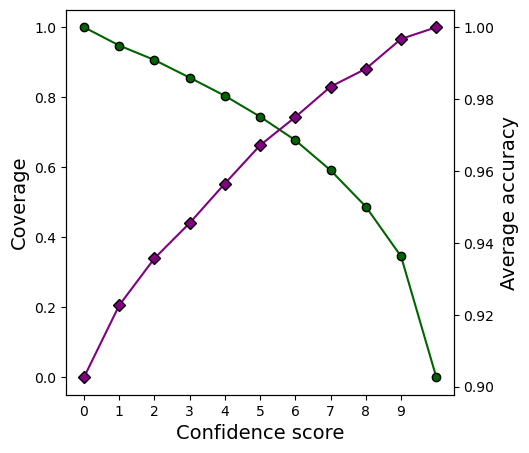

In [95]:
#plt.figure(figsize=(5, 5), dpi=150)
plot_conf_acc_cov(conf_good_df2)

In [121]:
conf_good_df1.to_pickle(os.path.join(results_dir, "good_confidence_data.pkl"))
conf_good_df2.to_pickle(os.path.join(results_dir, "good_confidence_data_sum.pkl"))

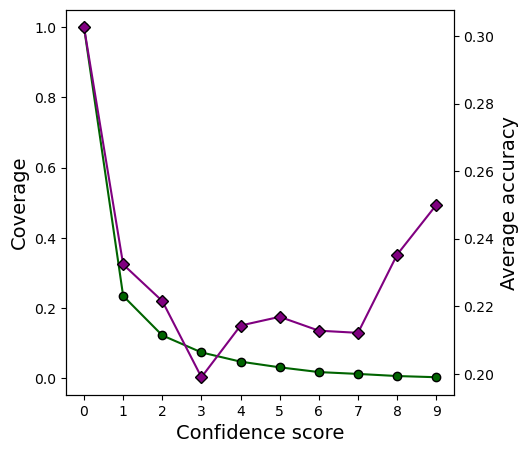

In [122]:
conf_rand_df1, conf_rand_df2 = get_confidences_df(ann_rand_preds, ann_rand_preds_round, ann_real_vals)
plot_conf_acc_cov(conf_rand_df2)

In [123]:
conf_rand_df1.to_pickle(os.path.join(results_dir, "rand_confidence_data.csv"))
conf_rand_df2.to_pickle(os.path.join(results_dir, "rand_confidence_data_sum.csv"))

## COMPARING CV ACCURACIES ACROSS METHODS AND BASELINES

In [124]:
print("Average 10-repeat 10-fold cross validation for KNN prediction = {}%".format(round(rskf_df.KNN_pred_acc.mean()*100,2)))

print("Average 10-repeat 10-fold cross validation for KNN random prediction = {}%".format(round(rskf_df.KNN_pred_acc_rand.mean()*100,2)))

print("Average 10-repeat 10-fold cross validation for ANN prediction = {}%".format(round(rskf_df.ANN_pred_acc.mean()*100,2)))

print("Average 10-repeat 10-fold cross validation for ANN random prediction = {}%".format(round(rskf_df.ANN_pred_acc_rand.mean()*100,2)))

print("Average 10-repeat 10-fold cross validation for random prediction = {}%".format(round(rskf_df.rand_acc.mean()*100,2)))

Average 10-repeat 10-fold cross validation for KNN prediction = 98.12%
Average 10-repeat 10-fold cross validation for KNN random prediction = 31.45%
Average 10-repeat 10-fold cross validation for ANN prediction = 90.27%
Average 10-repeat 10-fold cross validation for ANN random prediction = 30.25%
Average 10-repeat 10-fold cross validation for random prediction = 23.83%


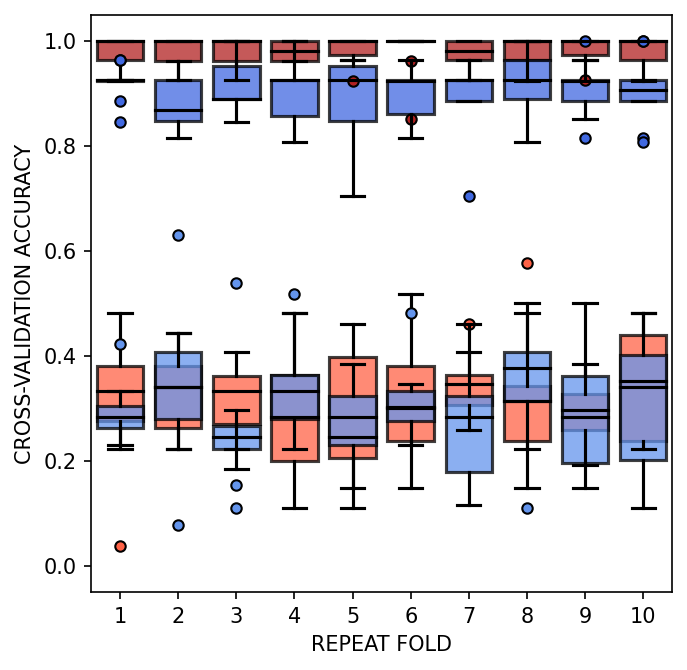

In [130]:
plt.figure(figsize=(5, 5), dpi=150)
plt.ylim(-0.05, 1.05)
ax1 = sns.boxplot(y = "KNN_pred_acc", x = "repeat_fold", data = rskf_df, color = "firebrick", **PROPS_pred_KNN, flierprops=flierprops_pred_KNN, saturation = 0.5)
sns.boxplot(y = "ANN_pred_acc", x = "repeat_fold", data = rskf_df, color = "royalblue", **PROPS_pred_ANN, flierprops=flierprops_pred_ANN, saturation = 0.5, ax = ax1)
sns.boxplot(y = "KNN_pred_acc_rand", x = "repeat_fold", data = rskf_df, color = "tomato", **PROPS_rand_KNN, flierprops=flierprops_rand_KNN, saturation = 0.5, ax = ax1)
sns.boxplot(y = "ANN_pred_acc_rand", x = "repeat_fold", data = rskf_df, color = "cornflowerblue", **PROPS_rand_ANN, flierprops=flierprops_rand_ANN, saturation = 0.5, ax = ax1)
#sns.boxplot(y = "rand_acc", x = "repeat_fold", data = rskf_df, color = "gold", **PROPS_rand, flierprops=flierprops_rand)

#plt.axhline(y=0.96, linestyle = "--", linewidth = 1, color = "firebrick")
#plt.axhline(y=0.86, linestyle = "--", linewidth = 2, color = "royalblue")
#plt.axhline(y=0.35, linestyle = "--", linewidth = 1, color = "tomato")
#plt.axhline(y=0.34, linestyle = "--", linewidth = 1, color = "cornflowerblue")
#plt.xticks(range(1,11))
#plt.legend()
plt.ylabel("CROSS-VALIDATION ACCURACY")
plt.xlabel("REPEAT FOLD")
for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.01))
plt.show()